Device utilisé: cpu
CLASSIFICATION D'IMAGES AVEC RESNET-18 - DATASET DÉSÉQUILIBRÉ

=== Analyse de Dataset d'entraînement ===
cat: 455 images (38.6%)
dog: 545 images (46.2%)
fleurs: 85 images (7.2%)
voitures: 95 images (8.1%)
Total: 1180 images
Ratio de déséquilibre: 6.41

=== Analyse de Dataset de test ===
cat: 200 images (34.8%)
dog: 200 images (34.8%)
fleurs: 85 images (14.8%)
voitures: 90 images (15.7%)
Total: 575 images
Ratio de déséquilibre: 2.35


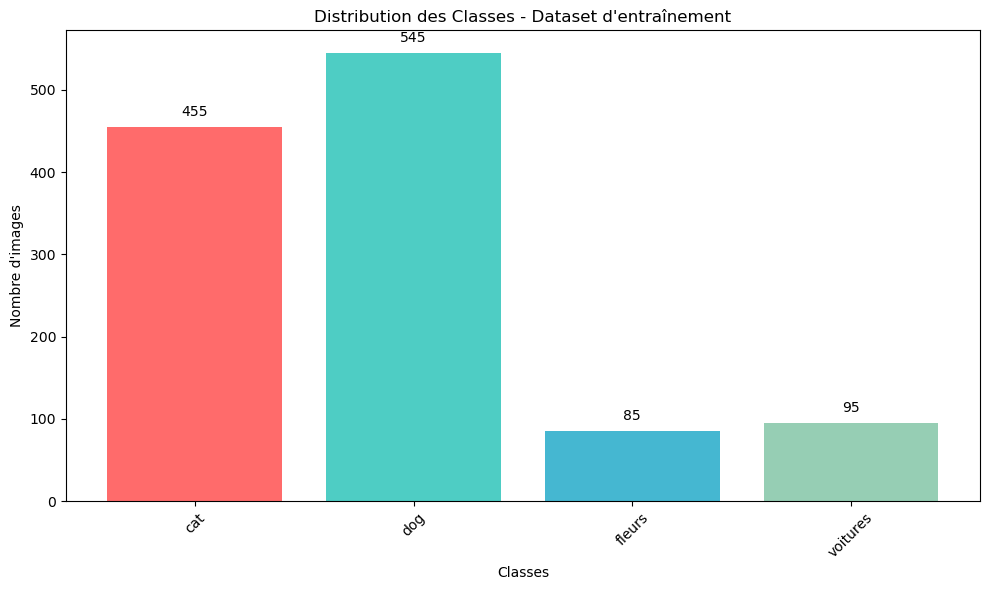

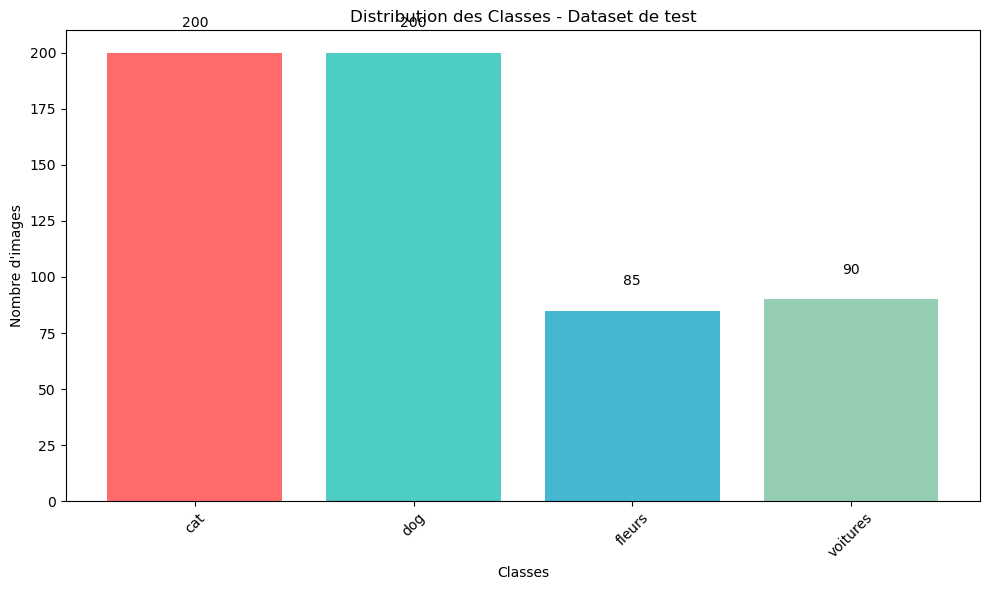

Classes trouvées: ['cat', 'dog', 'fleurs', 'voitures']
Nombre d'images d'entraînement: 1181
Nombre d'images de test: 576
✓ Utilisation du weighted sampler pour équilibrer les classes


C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Modèle ResNet-18 créé avec 4 classes: ['cat', 'dog', 'fleurs', 'voitures']
✓ Utilisation de poids de classes dans la loss function

Début de l'entraînement sur cpu
------------------------------------------------------------
Epoch [1/5] - LR: 0.001000
Train Loss: 0.3155, Train Acc: 81.29%
Test Loss: 0.7937, Test Acc: 79.17%
------------------------------------------------------------
Epoch [5/5] - LR: 0.001000
Train Loss: 0.1301, Train Acc: 89.84%
Test Loss: 0.2073, Test Acc: 92.36%
------------------------------------------------------------
Meilleure précision de test: 92.36%


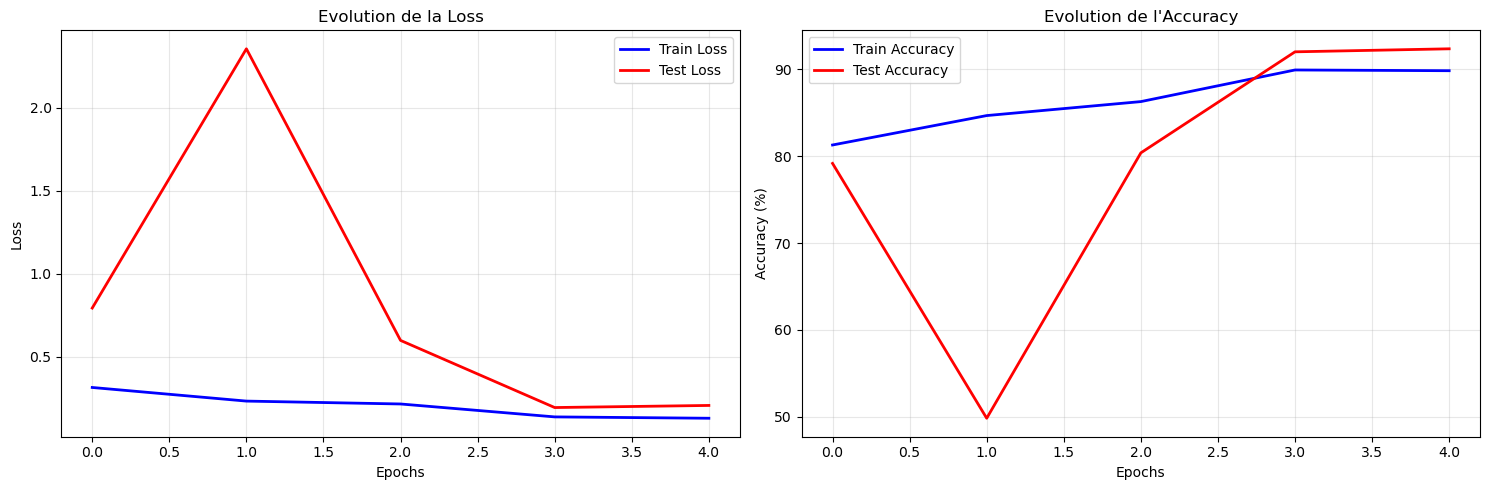


RAPPORT D'ÉVALUATION DÉTAILLÉ
Accuracy globale: 92.36%

Métriques par classe:
------------------------------------------------------------
cat             | Précision: 0.913 | Rappel: 0.890 | F1-Score: 0.901 | Support: 200
dog             | Précision: 0.918 | Rappel: 0.890 | F1-Score: 0.904 | Support: 200
fleurs          | Précision: 0.895 | Rappel: 1.000 | F1-Score: 0.944 | Support: 85
voitures        | Précision: 0.989 | Rappel: 1.000 | F1-Score: 0.995 | Support: 91
------------------------------------------------------------
Macro Average   | Précision: 0.929 | Rappel: 0.945 | F1-Score: 0.936
Weighted Average | Précision: 0.924 | Rappel: 0.924 | F1-Score: 0.923


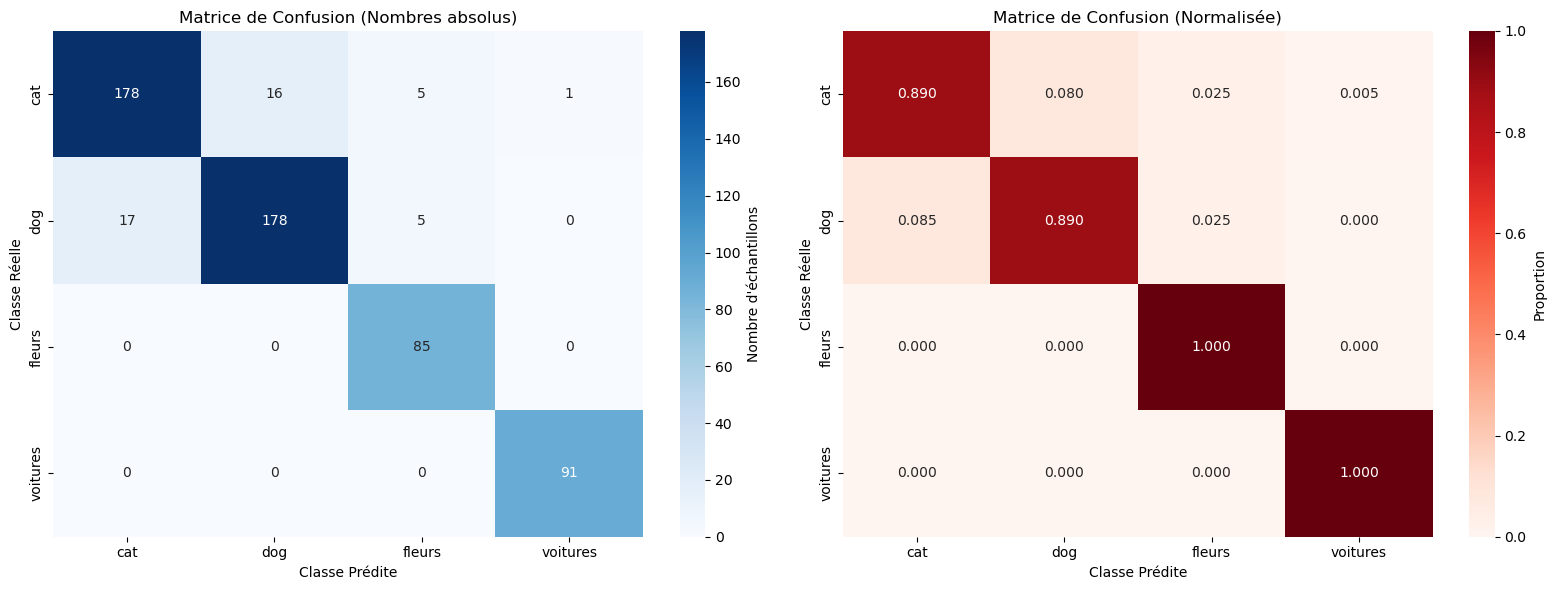

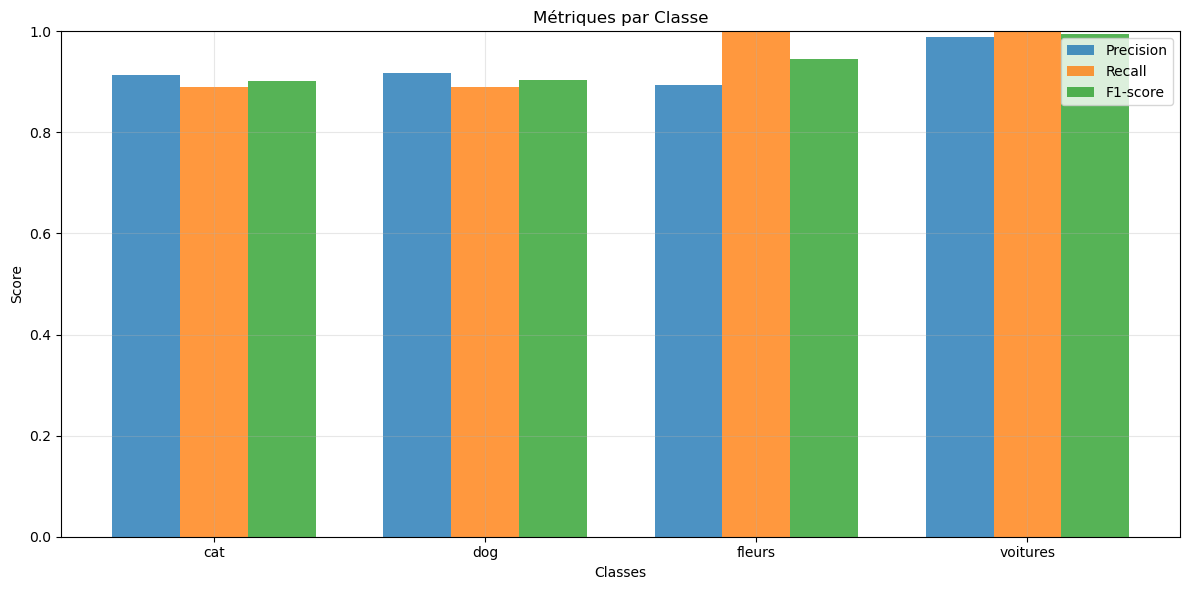


Modèle sauvegardé dans 'resnet18_balanced_model.pth'
Accuracy finale: 92.36%

Entraînement terminé avec succès!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from collections import Counter
import os
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import pandas as pd

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

# Paramètres
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
NUM_CLASSES = 4

# Chemins vers vos dossiers (à modifier selon votre structure)
TRAIN_DIR = "path/to/your/train"
TEST_DIR = "path/to/your/test"

class ImbalancedDatasetAnalyzer:
    """Classe pour analyser et traiter les datasets déséquilibrés"""
    
    def __init__(self, train_dir, test_dir):
        self.train_dir = train_dir
        self.test_dir = test_dir
        
    def analyze_class_distribution(self, dataset_path, dataset_name):
        """Analyser la distribution des classes"""
        print(f"\n=== Analyse de {dataset_name} ===")
        
        class_counts = {}
        total_samples = 0
        
        for class_name in os.listdir(dataset_path):
            class_path = os.path.join(dataset_path, class_name)
            if os.path.isdir(class_path):
                count = len([f for f in os.listdir(class_path) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                class_counts[class_name] = count
                total_samples += count
                
        # Affichage des statistiques
        for class_name, count in class_counts.items():
            percentage = (count / total_samples) * 100
            print(f"{class_name}: {count} images ({percentage:.1f}%)")
            
        print(f"Total: {total_samples} images")
        
        # Calcul du déséquilibre
        max_count = max(class_counts.values())
        min_count = min(class_counts.values())
        imbalance_ratio = max_count / min_count
        print(f"Ratio de déséquilibre: {imbalance_ratio:.2f}")
        
        return class_counts
    
    def plot_class_distribution(self, class_counts, title):
        """Visualiser la distribution des classes"""
        plt.figure(figsize=(10, 6))
        classes = list(class_counts.keys())
        counts = list(class_counts.values())
        
        bars = plt.bar(classes, counts, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
        plt.title(f'Distribution des Classes - {title}')
        plt.xlabel('Classes')
        plt.ylabel('Nombre d\'images')
        plt.xticks(rotation=45)
        
        # Ajouter les valeurs sur les barres
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                    str(count), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

def create_weighted_sampler(dataset):
    """Créer un sampler pondéré pour équilibrer les classes"""
    # Compter les échantillons par classe
    class_counts = Counter()
    for _, label in dataset:
        class_counts[label] += 1
    
    # Calculer les poids
    total_samples = len(dataset)
    class_weights = {class_idx: total_samples / count 
                    for class_idx, count in class_counts.items()}
    
    # Créer les poids pour chaque échantillon
    sample_weights = [class_weights[label] for _, label in dataset]
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

def get_transforms():
    """Définir les transformations avec augmentation de données"""
    
    # Transformations pour l'entraînement (avec augmentation)
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Transformations pour le test (sans augmentation)
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transforms, test_transforms

def create_data_loaders(train_dir, test_dir, batch_size=32, use_weighted_sampler=True):
    """Créer les data loaders avec équilibrage"""
    
    train_transforms, test_transforms = get_transforms()
    
    # Chargement des datasets
    train_dataset = ImageFolder(train_dir, transform=train_transforms)
    test_dataset = ImageFolder(test_dir, transform=test_transforms)
    
    print(f"Classes trouvées: {train_dataset.classes}")
    print(f"Nombre d'images d'entraînement: {len(train_dataset)}")
    print(f"Nombre d'images de test: {len(test_dataset)}")
    
    # Créer les data loaders
    if use_weighted_sampler:
        train_sampler = create_weighted_sampler(train_dataset)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                                sampler=train_sampler, num_workers=4)
        print("✓ Utilisation du weighted sampler pour équilibrer les classes")
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                                shuffle=True, num_workers=4)
        print("✓ Pas d'équilibrage des classes")
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                           shuffle=False, num_workers=4)
    
    return train_loader, test_loader, train_dataset.classes

def create_resnet18_model(num_classes=4, pretrained=True):
    """Créer le modèle ResNet-18"""
    model = torchvision.models.resnet18(pretrained=pretrained)
    
    # Modifier la dernière couche pour nos classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

def calculate_class_weights(dataset):
    """Calculer les poids des classes pour la loss function"""
    class_counts = Counter()
    for _, label in dataset:
        class_counts[label] += 1
    
    total_samples = len(dataset)
    num_classes = len(class_counts)
    
    # Calcul des poids inversement proportionnels à la fréquence
    class_weights = []
    for i in range(num_classes):
        weight = total_samples / (num_classes * class_counts[i])
        class_weights.append(weight)
    
    return torch.FloatTensor(class_weights)

def train_model(model, train_loader, test_loader, num_epochs=50, use_class_weights=True):
    """Entraîner le modèle avec suivi détaillé"""
    
    model = model.to(device)
    
    # Loss function avec pondération des classes si demandé
    if use_class_weights:
        # Calculer les poids des classes
        temp_dataset = ImageFolder(TRAIN_DIR, transform=transforms.ToTensor())
        class_weights = calculate_class_weights(temp_dataset).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        print("✓ Utilisation de poids de classes dans la loss function")
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    # Variables pour le suivi
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    best_test_acc = 0.0
    best_model_state = None
    
    print(f"\nDébut de l'entraînement sur {device}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        # Phase d'entraînement
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        
        # Phase de test
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_loss /= len(test_loader)
        test_acc = 100 * correct_test / total_test
        
        # Sauvegarder le meilleur modèle
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict().copy()
        
        # Stocker les métriques
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        # Ajuster le learning rate
        scheduler.step()
        
        # Affichage des résultats
        if (epoch + 1) % 5 == 0 or epoch == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f'Epoch [{epoch+1}/{num_epochs}] - LR: {current_lr:.6f}')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
            print('-' * 60)
    
    # Charger le meilleur modèle
    model.load_state_dict(best_model_state)
    print(f'Meilleure précision de test: {best_test_acc:.2f}%')
    
    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'best_accuracy': best_test_acc
    }

def plot_training_history(history):
    """Visualiser l'historique d'entraînement"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Courbes de loss
    ax1.plot(history['train_losses'], label='Train Loss', color='blue', linewidth=2)
    ax1.plot(history['test_losses'], label='Test Loss', color='red', linewidth=2)
    ax1.set_title('Evolution de la Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Courbes d'accuracy
    ax2.plot(history['train_accuracies'], label='Train Accuracy', color='blue', linewidth=2)
    ax2.plot(history['test_accuracies'], label='Test Accuracy', color='red', linewidth=2)
    ax2.set_title('Evolution de l\'Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, class_names):
    """Évaluation complète du modèle"""
    
    model.eval()
    all_predictions = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calcul des métriques
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels)) * 100
    
    # Rapport de classification détaillé
    report = classification_report(all_labels, all_predictions, 
                                 target_names=class_names, 
                                 output_dict=True)
    
    print("\n" + "="*60)
    print("RAPPORT D'ÉVALUATION DÉTAILLÉ")
    print("="*60)
    print(f"Accuracy globale: {accuracy:.2f}%")
    print("\nMétriques par classe:")
    print("-" * 60)
    
    for i, class_name in enumerate(class_names):
        precision = report[class_name]['precision']
        recall = report[class_name]['recall']
        f1 = report[class_name]['f1-score']
        support = int(report[class_name]['support'])
        
        print(f"{class_name:15s} | Précision: {precision:.3f} | Rappel: {recall:.3f} | "
              f"F1-Score: {f1:.3f} | Support: {support}")
    
    print("-" * 60)
    print(f"{'Macro Average':15s} | Précision: {report['macro avg']['precision']:.3f} | "
          f"Rappel: {report['macro avg']['recall']:.3f} | "
          f"F1-Score: {report['macro avg']['f1-score']:.3f}")
    print(f"{'Weighted Average':15s} | Précision: {report['weighted avg']['precision']:.3f} | "
          f"Rappel: {report['weighted avg']['recall']:.3f} | "
          f"F1-Score: {report['weighted avg']['f1-score']:.3f}")
    
    return all_predictions, all_labels, all_probs, report

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Afficher la matrice de confusion avec style amélioré"""
    
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Matrice de confusion en nombres absolus
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=ax1, cbar_kws={'label': 'Nombre d\'échantillons'})
    ax1.set_title('Matrice de Confusion (Nombres absolus)')
    ax1.set_xlabel('Classe Prédite')
    ax1.set_ylabel('Classe Réelle')
    
    # Matrice de confusion normalisée
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Reds',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax2, cbar_kws={'label': 'Proportion'})
    ax2.set_title('Matrice de Confusion (Normalisée)')
    ax2.set_xlabel('Classe Prédite')
    ax2.set_ylabel('Classe Réelle')
    
    plt.tight_layout()
    plt.show()
    
    return cm, cm_normalized

def plot_per_class_metrics(report, class_names):
    """Visualiser les métriques par classe"""
    
    metrics = ['precision', 'recall', 'f1-score']
    x = np.arange(len(class_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, metric in enumerate(metrics):
        values = [report[class_name][metric] for class_name in class_names]
        ax.bar(x + i * width, values, width, label=metric.capitalize(), alpha=0.8)
    
    ax.set_xlabel('Classes')
    ax.set_ylabel('Score')
    ax.set_title('Métriques par Classe')
    ax.set_xticks(x + width)
    ax.set_xticklabels(class_names)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def main():
    """Fonction principale"""
    
    print("="*80)
    print("CLASSIFICATION D'IMAGES AVEC RESNET-18 - DATASET DÉSÉQUILIBRÉ")
    print("="*80)
    
    # 1. Analyse du dataset
    analyzer = ImbalancedDatasetAnalyzer(TRAIN_DIR, TEST_DIR)
    train_dist = analyzer.analyze_class_distribution(TRAIN_DIR, "Dataset d'entraînement")
    test_dist = analyzer.analyze_class_distribution(TEST_DIR, "Dataset de test")
    
    # Visualisation des distributions
    analyzer.plot_class_distribution(train_dist, "Dataset d'entraînement")
    analyzer.plot_class_distribution(test_dist, "Dataset de test")
    
    # 2. Création des data loaders avec équilibrage
    train_loader, test_loader, class_names = create_data_loaders(
        TRAIN_DIR, TEST_DIR, BATCH_SIZE, use_weighted_sampler=True
    )
    
    # 3. Création du modèle
    model = create_resnet18_model(NUM_CLASSES, pretrained=True)
    print(f"\nModèle ResNet-18 créé avec {NUM_CLASSES} classes: {class_names}")
    
    # 4. Entraînement du modèle
    trained_model, history = train_model(
        model, train_loader, test_loader, NUM_EPOCHS, use_class_weights=True
    )
    
    # 5. Visualisation de l'entraînement
    plot_training_history(history)
    
    # 6. Évaluation complète
    predictions, true_labels, probabilities, report = evaluate_model(
        trained_model, test_loader, class_names
    )
    
    # 7. Matrice de confusion
    cm, cm_norm = plot_confusion_matrix(true_labels, predictions, class_names)
    
    # 8. Métriques par classe
    plot_per_class_metrics(report, class_names)
    
    # 9. Sauvegarde du modèle
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'class_names': class_names,
        'best_accuracy': history['best_accuracy'],
        'training_history': history
    }, 'resnet18_balanced_model.pth')
    
    print(f"\nModèle sauvegardé dans 'resnet18_balanced_model.pth'")
    print(f"Accuracy finale: {history['best_accuracy']:.2f}%")
    print("\nEntraînement terminé avec succès!")

if __name__ == "__main__":
    # Modifier ces chemins selon votre structure de dossiers
    TRAIN_DIR = r"C:\Users\user\Machine Learning\cats_dogs_light\train"
    TEST_DIR = r"C:\Users\user\Machine Learning\cats_dogs_light\test"
    
    main()

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

train_path = r"C:\Users\user\Machine Learning\cats_dogs_light\train"
val_path = r"C:\Users\user\Machine Learning\cats_dogs_light\test"

# Transformations avec data augmentation pour les classes minoritaires
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)

# Calculer les poids pour l'oversampling
class_counts = {0: 455, 1: 545, 2: 85, 3: 96}  # Votre distribution
num_samples = sum(class_counts.values())  # Total : 1181
class_weights = {i: 1.0 / count for i, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_dataset.targets]

# Créer un WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

# DataLoader avec sampler pour l'entraînement
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32)

# Vérifier la distribution après oversampling
labels_seen = []
for _, labels in train_loader:
    labels_seen.extend(labels.numpy())
print("Distribution après oversampling :", Counter(labels_seen))

Distribution après oversampling : Counter({2: 322, 3: 316, 1: 279, 0: 264})


Utilisation du device: cpu
Classes détectées: ['cat', 'dog', 'fleurs', 'voitures']

=== MÉTHODE: AUGMENTATION DE DONNÉES ===
Distribution originale: {0: 455, 1: 545, 2: 85, 3: 96}
Nombre cible d'échantillons par classe: 545
Distribution après équilibrage: {2: 545, 0: 545, 3: 545, 1: 545}


C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== DÉBUT DE L'ENTRAÎNEMENT (10 époques) ===
Époque 1/10:
  Loss d'entraînement: 0.4885
  Précision d'entraînement: 85.69%
  Précision de validation: 98.09%
  Précision par classe:
    cat: 96.00%
    dog: 99.00%
    fleurs: 100.00%
    voitures: 98.90%

Époque 2/10:
  Loss d'entraînement: 0.1720
  Précision d'entraînement: 95.69%
  Précision de validation: 97.40%
  Précision par classe:
    cat: 93.50%
    dog: 99.50%
    fleurs: 100.00%
    voitures: 98.90%

Époque 3/10:
  Loss d'entraînement: 0.1315
  Précision d'entraînement: 96.47%
  Précision de validation: 97.74%
  Précision par classe:
    cat: 94.00%
    dog: 99.50%
    fleurs: 100.00%
    voitures: 100.00%

Époque 4/10:
  Loss d'entraînement: 0.0978
  Précision d'entraînement: 97.02%
  Précision de validation: 98.26%
  Précision par classe:
    cat: 95.50%
    dog: 99.50%
    fleurs: 100.00%
    voitures: 100.00%

Époque 5/10:
  Loss d'entraînement: 0.0897
  Précision d'entraînement: 97.34%
  Précision de validation: 98.61%


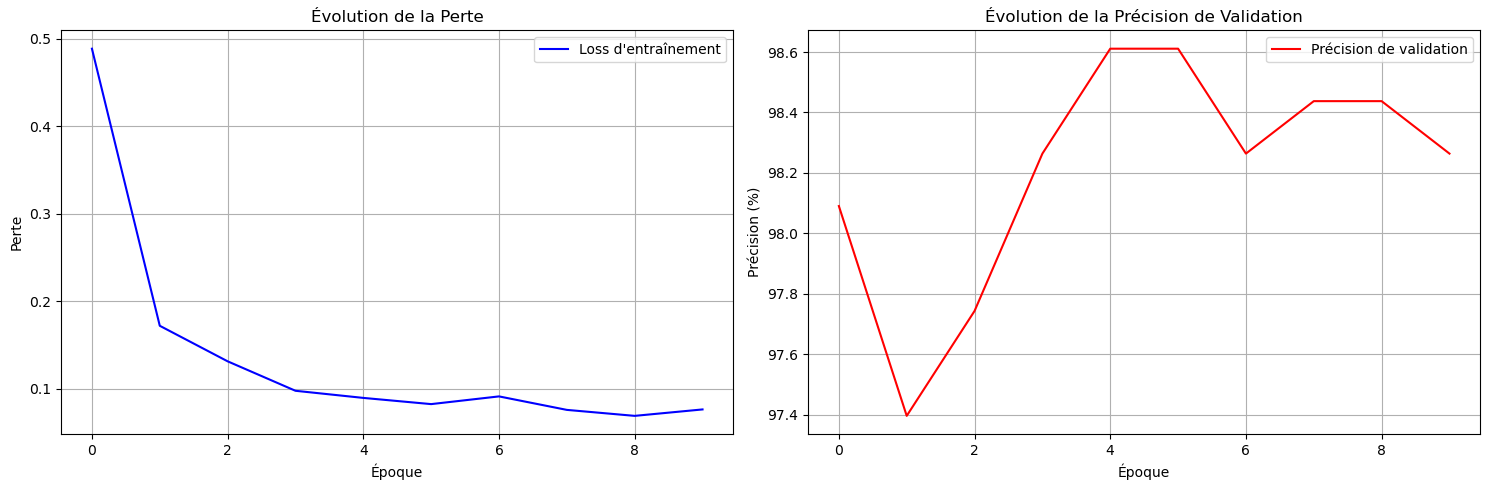


=== ÉVALUATION DÉTAILLÉE ===
Précision globale: 98.26%

Précision par classe:
  cat: 95.00% (190/200)
  dog: 100.00% (200/200)
  fleurs: 100.00% (85/85)
  voitures: 100.00% (91/91)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance, ImageFilter
import random
import os
import copy
from sklearn.utils.class_weight import compute_class_weight

class BalancedImageDataset(Dataset):
    """
    Dataset personnalisé pour équilibrer les classes avec oversampling
    """
    def __init__(self, original_dataset, balance_method='oversample', target_samples=None):
        self.original_dataset = original_dataset
        self.balance_method = balance_method
        self.classes = original_dataset.classes
        self.class_to_idx = original_dataset.class_to_idx
        
        # Analyser la distribution originale
        self.original_distribution = Counter(original_dataset.targets)
        print("Distribution originale:", dict(self.original_distribution))
        
        # Définir le nombre cible d'échantillons par classe
        if target_samples is None:
            self.target_samples = max(self.original_distribution.values())
        else:
            self.target_samples = target_samples
            
        print(f"Nombre cible d'échantillons par classe: {self.target_samples}")
        
        # Créer les indices équilibrés
        self.balanced_indices = self._create_balanced_indices()
        
        print("Distribution après équilibrage:", 
              dict(Counter([original_dataset.targets[idx] for idx in self.balanced_indices])))
    
    def _create_balanced_indices(self):
        """Créer des indices équilibrés selon la méthode choisie"""
        balanced_indices = []
        
        for class_idx in range(len(self.classes)):
            # Obtenir tous les indices de cette classe
            class_indices = [i for i, target in enumerate(self.original_dataset.targets) 
                           if target == class_idx]
            
            current_count = len(class_indices)
            needed_samples = self.target_samples
            
            if current_count >= needed_samples:
                # Si on a assez d'échantillons, on en sélectionne aléatoirement
                selected_indices = np.random.choice(class_indices, needed_samples, replace=False)
            else:
                # Oversampling nécessaire
                # D'abord, ajouter tous les échantillons existants
                selected_indices = class_indices.copy()
                
                # Puis ajouter des échantillons dupliqués aléatoirement
                additional_needed = needed_samples - current_count
                additional_indices = np.random.choice(class_indices, additional_needed, replace=True)
                selected_indices.extend(additional_indices.tolist())
            
            balanced_indices.extend(selected_indices)
        
        # Mélanger les indices
        np.random.shuffle(balanced_indices)
        return balanced_indices
    
    def __len__(self):
        return len(self.balanced_indices)
    
    def __getitem__(self, idx):
        original_idx = self.balanced_indices[idx]
        return self.original_dataset[original_idx]

class AdvancedAugmentationTransform:
    """
    Classe pour appliquer des augmentations avancées
    """
    def __init__(self, base_transform=None):
        self.base_transform = base_transform
        
    def __call__(self, img):
        # Appliquer les transformations de base d'abord
        if self.base_transform:
            img = self.base_transform(img)
        
        # Appliquer des augmentations avancées avec probabilité
        if random.random() > 0.5:
            img = self._apply_advanced_augmentation(img)
            
        return img
    
    def _apply_advanced_augmentation(self, img):
        """Appliquer des augmentations avancées"""
        # Convertir en PIL si nécessaire
        if torch.is_tensor(img):
            img = TF.to_pil_image(img)
        
        # Liste des augmentations possibles
        augmentations = [
            self._random_rotation,
            self._random_brightness,
            self._random_contrast,
            self._random_saturation,
            self._random_blur
        ]
        
        # Appliquer 1-3 augmentations aléatoirement
        num_augs = random.randint(1, 3)
        selected_augs = random.sample(augmentations, num_augs)
        
        for aug in selected_augs:
            img = aug(img)
        
        return img
    
    def _random_rotation(self, img):
        angle = random.uniform(-15, 15)
        return TF.rotate(img, angle, fill=(255, 255, 255))
    
    def _random_brightness(self, img):
        factor = random.uniform(0.8, 1.2)
        enhancer = ImageEnhance.Brightness(img)
        return enhancer.enhance(factor)
    
    def _random_contrast(self, img):
        factor = random.uniform(0.8, 1.2)
        enhancer = ImageEnhance.Contrast(img)
        return enhancer.enhance(factor)
    
    def _random_saturation(self, img):
        factor = random.uniform(0.8, 1.2)
        enhancer = ImageEnhance.Color(img)
        return enhancer.enhance(factor)
    
    def _random_blur(self, img):
        if random.random() > 0.7:
            return img.filter(ImageFilter.GaussianBlur(radius=0.5))
        return img

class DatasetBalancer:
    """
    Classe principale pour équilibrer le dataset et entraîner le modèle
    """
    def __init__(self, train_path, val_path):
        self.train_path = train_path
        self.val_path = val_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Utilisation du device: {self.device}")
        
        # Transformations de base
        self.base_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                               [0.229, 0.224, 0.225])
        ])
        
        # Transformations avec augmentation
        self.augmented_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], 
                               [0.229, 0.224, 0.225])
        ])
    
    def load_original_datasets(self):
        """Charger les datasets originaux"""
        self.original_train_dataset = datasets.ImageFolder(self.train_path, transform=self.base_transform)
        self.val_dataset = datasets.ImageFolder(self.val_path, transform=self.base_transform)
        
        print("Classes détectées:", self.original_train_dataset.classes)
        return self.original_train_dataset, self.val_dataset
    
    def analyze_class_distribution(self, dataset):
        """Analyser la distribution des classes"""
        distribution = Counter(dataset.targets)
        
        print("\n=== ANALYSE DE LA DISTRIBUTION ===")
        for class_idx, class_name in enumerate(dataset.classes):
            count = distribution[class_idx]
            percentage = (count / len(dataset.targets)) * 100
            print(f"{class_name}: {count} échantillons ({percentage:.1f}%)")
        
        # Calcul du ratio de déséquilibre
        max_samples = max(distribution.values())
        min_samples = min(distribution.values())
        imbalance_ratio = max_samples / min_samples
        print(f"\nRatio de déséquilibre: {imbalance_ratio:.2f}:1")
        
        return distribution
    
    def visualize_distribution(self, original_dist, balanced_dist=None):
        """Visualiser la distribution des classes"""
        fig, axes = plt.subplots(1, 2 if balanced_dist else 1, figsize=(15, 6))
        
        if balanced_dist is None:
            axes = [axes]
        
        class_names = self.original_train_dataset.classes
        
        # Distribution originale
        original_counts = [original_dist[i] for i in range(len(class_names))]
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        
        bars1 = axes[0].bar(class_names, original_counts, color=colors)
        axes[0].set_title('Distribution Originale', fontsize=14, fontweight='bold')
        axes[0].set_ylabel('Nombre d\'échantillons')
        axes[0].set_xlabel('Classes')
        
        # Ajouter les valeurs sur les barres
        for bar, count in zip(bars1, original_counts):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                        str(count), ha='center', va='bottom', fontweight='bold')
        
        if balanced_dist:
            # Distribution équilibrée
            balanced_counts = [balanced_dist[i] for i in range(len(class_names))]
            bars2 = axes[1].bar(class_names, balanced_counts, color=colors)
            axes[1].set_title('Distribution Équilibrée', fontsize=14, fontweight='bold')
            axes[1].set_ylabel('Nombre d\'échantillons')
            axes[1].set_xlabel('Classes')
            
            # Ajouter les valeurs sur les barres
            for bar, count in zip(bars2, balanced_counts):
                axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                            str(count), ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def create_balanced_dataset(self, method='oversample'):
        """
        Créer un dataset équilibré
        Méthodes disponibles: 'oversample', 'weighted_sampler', 'augmentation'
        """
        if method == 'oversample':
            return self._oversample_method()
        elif method == 'weighted_sampler':
            return self._weighted_sampler_method()
        elif method == 'augmentation':
            return self._augmentation_method()
        else:
            raise ValueError("Méthode non supportée. Utilisez 'oversample', 'weighted_sampler', ou 'augmentation'")
    
    def _oversample_method(self):
        """Méthode 1: Oversampling simple avec duplication"""
        print("\n=== MÉTHODE: OVERSAMPLING SIMPLE ===")
        
        balanced_dataset = BalancedImageDataset(self.original_train_dataset)
        balanced_loader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)
        
        return balanced_dataset, balanced_loader
    
    def _weighted_sampler_method(self):
        """Méthode 2: WeightedRandomSampler"""
        print("\n=== MÉTHODE: WEIGHTED RANDOM SAMPLER ===")
        
        # Calculer les poids pour chaque classe
        class_counts = Counter(self.original_train_dataset.targets)
        total_samples = len(self.original_train_dataset.targets)
        
        # Poids inversement proportionnels à la fréquence des classes
        class_weights = {class_idx: total_samples / count 
                        for class_idx, count in class_counts.items()}
        
        # Créer un poids pour chaque échantillon
        sample_weights = [class_weights[target] for target in self.original_train_dataset.targets]
        
        # Créer le sampler
        sampler = WeightedRandomSampler(weights=sample_weights, 
                                      num_samples=len(sample_weights), 
                                      replacement=True)
        
        # Créer le DataLoader avec le sampler
        balanced_loader = DataLoader(self.original_train_dataset, 
                                   batch_size=32, 
                                   sampler=sampler)
        
        print("Poids des classes:", class_weights)
        
        return self.original_train_dataset, balanced_loader
    
    def _augmentation_method(self):
        """Méthode 3: Augmentation de données ciblée"""
        print("\n=== MÉTHODE: AUGMENTATION DE DONNÉES ===")
        
        # Créer un dataset avec augmentation pour les classes minoritaires
        augmented_dataset = datasets.ImageFolder(self.train_path, transform=self.augmented_transform)
        balanced_dataset = BalancedImageDataset(augmented_dataset)
        balanced_loader = DataLoader(balanced_dataset, batch_size=32, shuffle=True)
        
        return balanced_dataset, balanced_loader
    
    def create_model(self, num_classes=4):
        """Créer le modèle ResNet"""
        model = models.resnet18(pretrained=True)
        
        # Geler les couches convolutionnelles
        for param in model.parameters():
            param.requires_grad = False
        
        # Adapter la couche finale
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
        
        model = model.to(self.device)
        return model
    
    def train_model(self, model, train_loader, val_loader, epochs=10, use_class_weights=False):
        """Entraîner le modèle avec le dataset équilibré"""
        
        # Définir la fonction de perte
        if use_class_weights:
            # Calculer les poids des classes pour la fonction de perte
            class_counts = Counter(self.original_train_dataset.targets)
            class_weights = compute_class_weight('balanced', 
                                               classes=np.unique(self.original_train_dataset.targets),
                                               y=self.original_train_dataset.targets)
            class_weights = torch.FloatTensor(class_weights).to(self.device)
            criterion = nn.CrossEntropyLoss(weight=class_weights)
            print("Utilisation de poids de classe dans la fonction de perte")
        else:
            criterion = nn.CrossEntropyLoss()
        
        optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        
        # Listes pour stocker les métriques
        train_losses = []
        val_accuracies = []
        
        print(f"\n=== DÉBUT DE L'ENTRAÎNEMENT ({epochs} époques) ===")
        
        for epoch in range(epochs):
            # Phase d'entraînement
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                # Calculer la précision d'entraînement
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
            
            avg_train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct_train / total_train
            train_losses.append(avg_train_loss)
            
            # Phase de validation
            model.eval()
            correct_val = 0
            total_val = 0
            class_correct = list(0. for i in range(4))
            class_total = list(0. for i in range(4))
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    
                    # Statistiques par classe
                    c = (predicted == labels).squeeze()
                    for i in range(labels.size(0)):
                        label = labels[i]
                        class_correct[label] += c[i].item()
                        class_total[label] += 1
            
            val_accuracy = 100 * correct_val / total_val
            val_accuracies.append(val_accuracy)
            
            # Mise à jour du scheduler
            scheduler.step()
            
            print(f"Époque {epoch+1}/{epochs}:")
            print(f"  Loss d'entraînement: {avg_train_loss:.4f}")
            print(f"  Précision d'entraînement: {train_accuracy:.2f}%")
            print(f"  Précision de validation: {val_accuracy:.2f}%")
            
            # Précision par classe
            class_names = self.original_train_dataset.classes
            print("  Précision par classe:")
            for i in range(4):
                if class_total[i] > 0:
                    class_acc = 100 * class_correct[i] / class_total[i]
                    print(f"    {class_names[i]}: {class_acc:.2f}%")
            print()
        
        # Graphique des métriques
        self._plot_training_metrics(train_losses, val_accuracies)
        
        return model, train_losses, val_accuracies
    
    def _plot_training_metrics(self, train_losses, val_accuracies):
        """Afficher les graphiques des métriques d'entraînement"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Graphique des pertes
        ax1.plot(train_losses, 'b-', label='Loss d\'entraînement')
        ax1.set_title('Évolution de la Perte')
        ax1.set_xlabel('Époque')
        ax1.set_ylabel('Perte')
        ax1.legend()
        ax1.grid(True)
        
        # Graphique de la précision
        ax2.plot(val_accuracies, 'r-', label='Précision de validation')
        ax2.set_title('Évolution de la Précision de Validation')
        ax2.set_xlabel('Époque')
        ax2.set_ylabel('Précision (%)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_model_detailed(self, model, val_loader):
        """Évaluation détaillée du modèle"""
        model.eval()
        
        all_predictions = []
        all_labels = []
        class_correct = list(0. for i in range(4))
        class_total = list(0. for i in range(4))
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Statistiques par classe
                c = (predicted == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        
        # Calcul des métriques globales
        total_accuracy = 100 * sum(class_correct) / sum(class_total)
        
        print("\n=== ÉVALUATION DÉTAILLÉE ===")
        print(f"Précision globale: {total_accuracy:.2f}%")
        print("\nPrécision par classe:")
        
        class_names = self.original_train_dataset.classes
        for i in range(4):
            if class_total[i] > 0:
                class_accuracy = 100 * class_correct[i] / class_total[i]
                print(f"  {class_names[i]}: {class_accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})")
        
        return total_accuracy, class_correct, class_total

# EXEMPLE D'UTILISATION COMPLÈTE
def main():
    """Fonction principale pour démontrer l'utilisation"""
    
    # Initialiser le balanceur
    train_path = r"C:\Users\user\Machine Learning\cats_dogs_light\train"
    val_path = r"C:\Users\user\Machine Learning\cats_dogs_light\test"
    
    balancer = DatasetBalancer(train_path, val_path)
    
    # Charger les datasets originaux
    original_train_dataset, val_dataset = balancer.load_original_datasets()
    
    # Analyser la distribution originale
    original_distribution = balancer.analyze_class_distribution(original_train_dataset)
    
    # Créer les DataLoaders de validation
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    print("\n" + "="*60)
    print("COMPARAISON DES MÉTHODES D'ÉQUILIBRAGE")
    print("="*60)
    
    methods = [
        ('oversample', 'Oversampling Simple'),
        ('weighted_sampler', 'Weighted Random Sampler'),
        ('augmentation', 'Augmentation de Données')
    ]
    
    results = {}
    
    for method_key, method_name in methods:
        print(f"\n{'='*20} {method_name} {'='*20}")
        
        # Créer le dataset équilibré
        balanced_dataset, balanced_loader = balancer.create_balanced_dataset(method=method_key)
        
        # Analyser la nouvelle distribution
        if hasattr(balanced_dataset, 'targets'):
            balanced_distribution = Counter(balanced_dataset.targets)
        else:
            # Pour WeightedRandomSampler, on utilise la distribution originale
            balanced_distribution = original_distribution
        
        # Visualiser les distributions
        balancer.visualize_distribution(original_distribution, balanced_distribution)
        
        # Créer et entraîner le modèle
        model = balancer.create_model()
        
        # Utiliser des poids de classe pour certaines méthodes
        use_weights = method_key in ['weighted_sampler']
        
        trained_model, losses, accuracies = balancer.train_model(
            model, balanced_loader, val_loader, 
            epochs=8, use_class_weights=use_weights
        )
        
        # Évaluation détaillée
        final_accuracy, class_correct, class_total = balancer.evaluate_model_detailed(
            trained_model, val_loader
        )
        
        results[method_name] = {
            'final_accuracy': final_accuracy,
            'class_accuracies': [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 
                               for i in range(4)]
        }
    
    # Résumé final
    print("\n" + "="*60)
    print("RÉSUMÉ COMPARATIF DES MÉTHODES")
    print("="*60)
    
    for method_name, result in results.items():
        print(f"\n{method_name}:")
        print(f"  Précision globale: {result['final_accuracy']:.2f}%")
        print("  Précision par classe:")
        class_names = ['cat', 'dog', 'fleurs', 'voitures']
        for i, (class_name, acc) in enumerate(zip(class_names, result['class_accuracies'])):
            print(f"    {class_name}: {acc:.2f}%")

if __name__ == "__main__":
    # Pour utiliser le code, décommentez la ligne suivante:
    # main()
    
    # OU utilisez directement avec vos données:
    
    # Exemple d'utilisation rapide
    train_path = r"C:\Users\user\Machine Learning\cats_dogs_light\train"
    val_path = r"C:\Users\user\Machine Learning\cats_dogs_light\test"
    
    balancer = DatasetBalancer(train_path, val_path)
    original_train, val_dataset = balancer.load_original_datasets()
    
    # Méthode recommandée: Oversampling avec augmentation
    balanced_dataset, balanced_loader = balancer.create_balanced_dataset(method='augmentation')
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Créer et entraîner le modèle
    model = balancer.create_model()
    trained_model, _, _ = balancer.train_model(model, balanced_loader, val_loader, epochs=10)
    
    # Évaluation finale
    balancer.evaluate_model_detailed(trained_model, val_loader)